# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [89]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

from ast import literal_eval
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('/home/kadichari/kadicharivic/projeto_capstone_Arvato/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('/home/kadichari/kadicharivic/projeto_capstone_Arvato/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias_test = azdias
customers_test = customers

/home/kadichari/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Viewing the data

In [3]:
# Print number of rows and columns in the azdias and customers dataframe

print(customers.shape)
print(azdias.shape)

(191652, 369)
(891221, 366)


In [4]:
#Print first 10 rows of the azdias dataframe
azdias.head(10)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [7]:
#missing values
azdias_missing_values = azdias.isnull().sum()

#percentage of missing values
azdias_missing_values_percent = azdias_missing_values / len(azdias) * 100

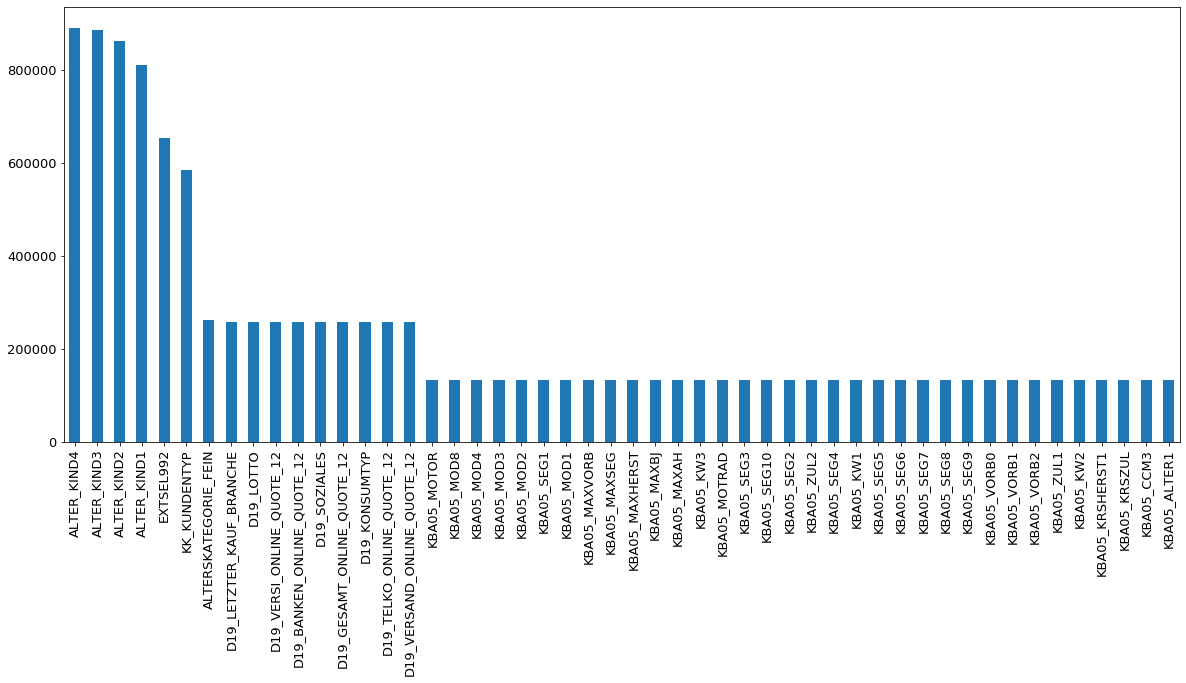

In [8]:
(azdias_missing_values.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))

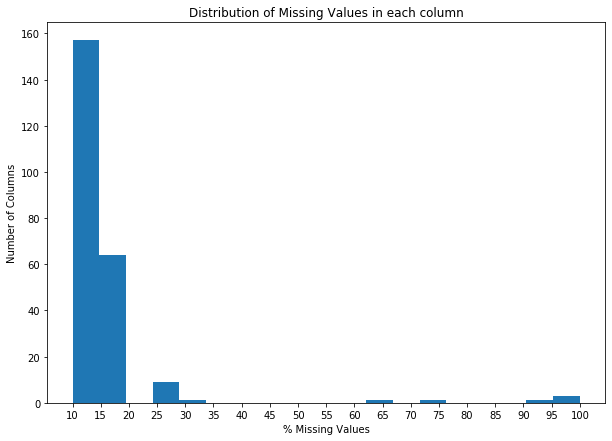

In [9]:
#percentage of empty fields

fig = plt.figure(figsize=(10,7))
plt.hist(azdias_missing_values_percent, bins=np.linspace(10,100,20))
plt.title('Distribution of Missing Values in each column');
plt.xticks(np.linspace(10,100,19))
plt.xlabel('% Missing Values')
plt.ylabel('Number of Columns');


In [10]:
# % of missing data in columns
print('% Missing Values','\n',azdias_missing_values_percent.sort_values(ascending=False))

% Missing Values 
 ALTER_KIND4               99.864792
ALTER_KIND3               99.307691
ALTER_KIND2               96.690047
ALTER_KIND1               90.904837
EXTSEL992                 73.399639
                            ...    
D19_VERSI_ONLINE_DATUM     0.000000
D19_VERSICHERUNGEN         0.000000
D19_VOLLSORTIMENT          0.000000
D19_WEIN_FEINKOST          0.000000
LNR                        0.000000
Length: 366, dtype: float64


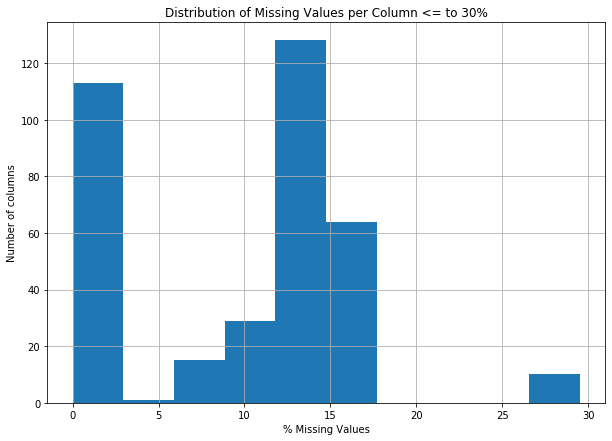

In [11]:
#columns that have missing values less than or equal to 30%
lower_value_30 = azdias_missing_values_percent[azdias_missing_values_percent<=30]
fig = plt.figure(figsize=(10,7))
lower_value_30.hist()
plt.title('Distribution of Missing Values per Column <= to 30%');
plt.xlabel('% Missing Values')
plt.ylabel('Number of columns');

In [12]:
lower_value_30

LNR                      0.000000
AGER_TYP                 0.000000
AKT_DAT_KL               8.247000
ALTER_HH                 8.247000
ALTERSKATEGORIE_FEIN    29.504130
                          ...    
WOHNDAUER_2008           8.247000
WOHNLAGE                10.451729
ZABEOTYP                 0.000000
ANREDE_KZ                0.000000
ALTERSKATEGORIE_GROB     0.000000
Length: 360, dtype: float64

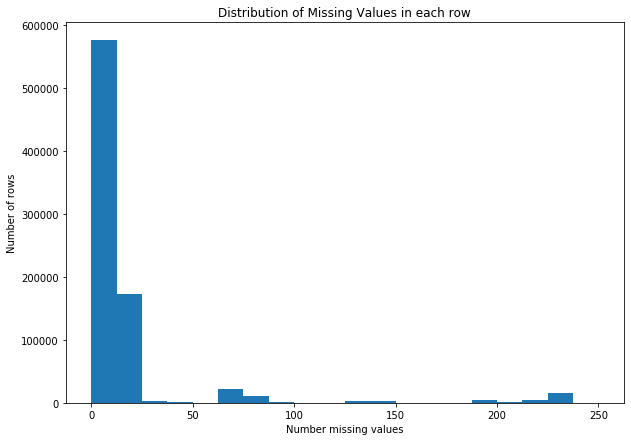

In [13]:
#analyze missing values in rows
rows_null = azdias.isnull().sum(axis=1)

fig = plt.figure(figsize=(10,7))
plt.hist(rows_null, bins=np.linspace(0,250,21))
plt.title('Distribution of Missing Values in each row');
# plt.xticks(np.linspace(10,250,21))
plt.xlabel('Number missing values')
plt.ylabel('Number of rows');

In [14]:
#percentage of dataframe added in each row
azdias.isnull().sum(axis=1).value_counts().sort_index().cumsum()[:40]/ len(azdias) * 100

0      0.033886
1      0.212293
2      0.996386
3      3.208856
4     16.583541
5     37.966228
6     56.098543
7     61.873654
8     63.318077
9     63.872934
10    64.066040
11    64.290114
12    64.518565
13    64.701685
14    65.184842
15    72.662336
16    82.272186
17    82.839498
18    83.348126
19    83.452589
20    83.515200
21    83.628752
22    83.731420
23    83.807271
24    83.888957
25    83.976702
26    84.033814
27    84.070057
28    84.145234
29    84.207733
30    84.219739
31    84.221983
32    84.222993
33    84.223778
34    84.225349
35    84.233091
36    84.236906
37    84.245883
38    84.285155
39    84.302210
dtype: float64

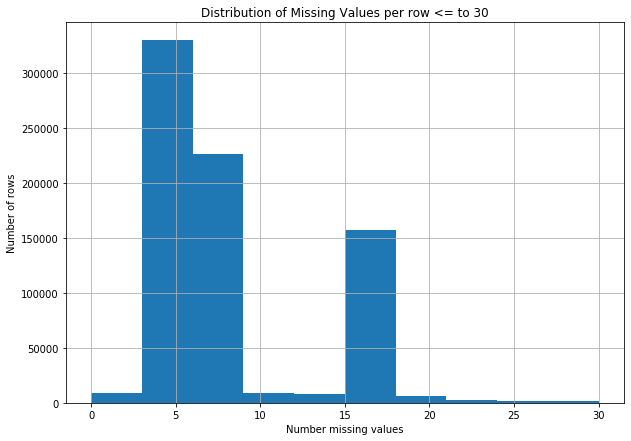

In [28]:
row_null = azdias[azdias.isnull().sum(axis=1) <=30].isnull().sum(axis=1)

fig = plt.figure(figsize=(10,7))
row_null.hist()
plt.title('Distribution of Missing Values per row <= to 30');
plt.xlabel('Number missing values')
plt.ylabel('Number of rows');

We can analyze that the majority 84% of the dataframe lines present between 0 to 30 missing values, therefore, we will remove the lines that have more than 30 missing values.

#### Viewing the dataframe customers

In [16]:
customers.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


In [17]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [18]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [19]:
#missing values
customers_missing_values = customers.isnull().sum()

#percentage of missing values
customers_missing_values_percent = customers_missing_values / len(customers) * 100

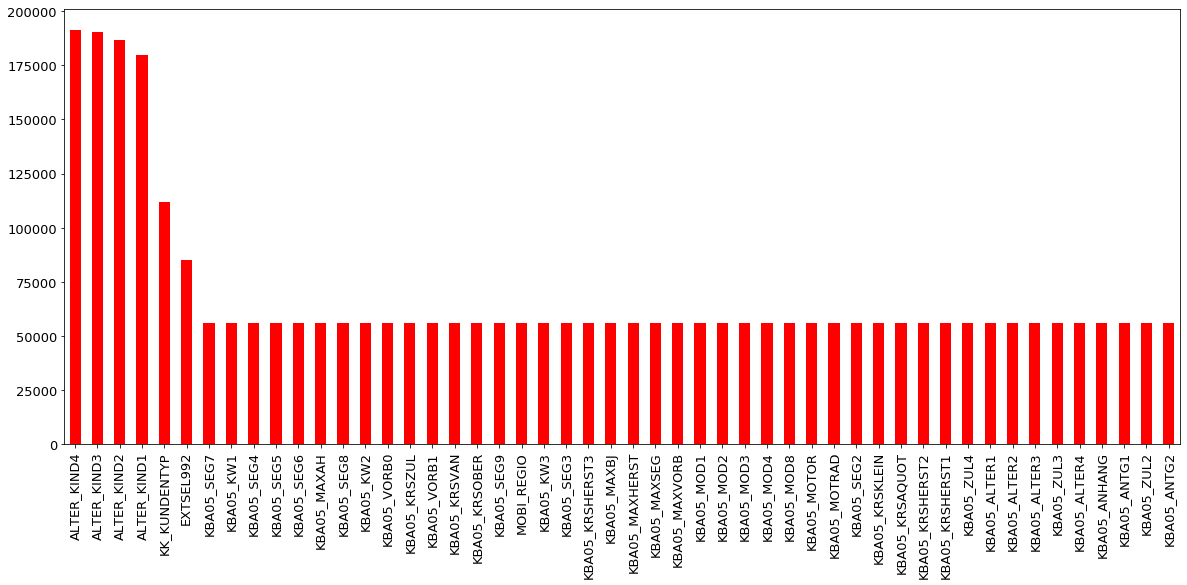

In [20]:
(customers_missing_values.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13, color='r'))

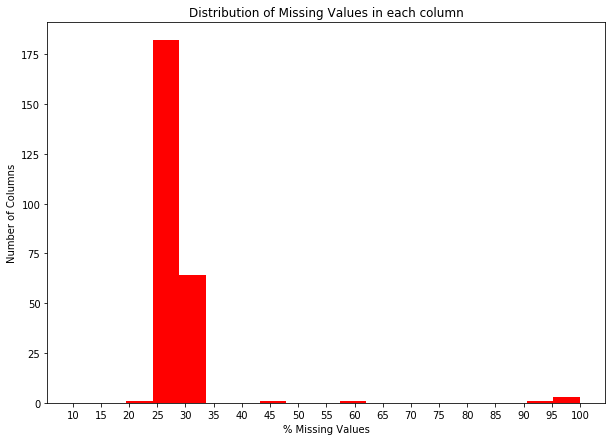

In [21]:
#percentage of empty fields

fig = plt.figure(figsize=(10,7))
plt.hist(customers_missing_values_percent, bins=np.linspace(10,100,20), color='r')
plt.title('Distribution of Missing Values in each column');
plt.xticks(np.linspace(10,100,19))
plt.xlabel('% Missing Values')
plt.ylabel('Number of Columns');

In [22]:
# % of missing data in columns
print('% Missing Values','\n',customers_missing_values_percent.sort_values(ascending=False))

% Missing Values 
 ALTER_KIND4          99.876860
ALTER_KIND3          99.334732
ALTER_KIND2          97.338927
ALTER_KIND1          93.860748
KK_KUNDENTYP         58.406382
                       ...    
D19_VOLLSORTIMENT     0.000000
D19_WEIN_FEINKOST     0.000000
FINANZ_ANLEGER        0.000000
FINANZ_HAUSBAUER      0.000000
LNR                   0.000000
Length: 369, dtype: float64


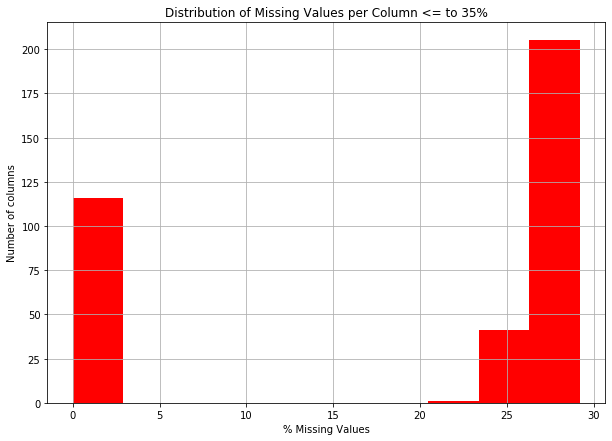

In [23]:
#columns that have missing values less than or equal to 35%
lower_value_35 = customers_missing_values_percent[customers_missing_values_percent<=35]
fig = plt.figure(figsize=(10,7))
lower_value_35.hist(color='r')
plt.title('Distribution of Missing Values per Column <= to 35%');
plt.xlabel('% Missing Values')
plt.ylabel('Number of columns');

In [24]:
lower_value_35

LNR                      0.000000
AGER_TYP                 0.000000
AKT_DAT_KL              24.312817
ALTER_HH                24.312817
ALTERSKATEGORIE_FEIN    27.050070
                          ...    
PRODUCT_GROUP            0.000000
CUSTOMER_GROUP           0.000000
ONLINE_PURCHASE          0.000000
ANREDE_KZ                0.000000
ALTERSKATEGORIE_GROB     0.000000
Length: 363, dtype: float64

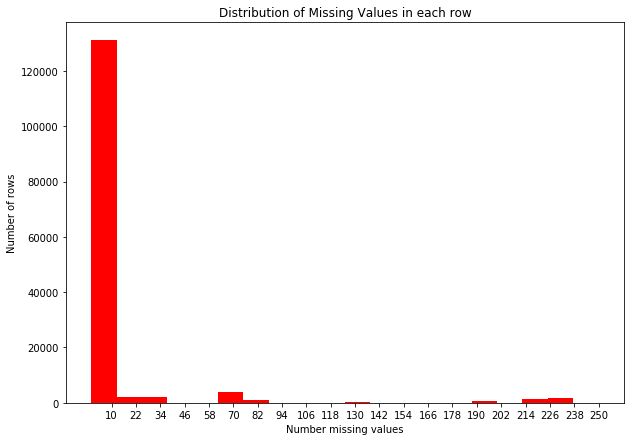

In [25]:
#analyze missing values in rows
rows_null_customers = customers.isnull().sum(axis=1)

fig = plt.figure(figsize=(10,7))
plt.hist(rows_null_customers, bins=np.linspace(0,250,21), color='r')
plt.title('Distribution of Missing Values in each row');
plt.xticks(np.linspace(10,250,21))
plt.xlabel('Number missing values')
plt.ylabel('Number of rows');

In [26]:
#percentage of dataframe added in each row
customers.isnull().sum(axis=1).value_counts().sort_index().cumsum()[:60]/ len(customers) * 100

0      0.070962
1      0.339156
2      1.328449
3      3.485484
4     30.296057
5     55.371715
6     63.856365
7     66.028009
8     67.432117
9     67.819798
10    68.048859
11    68.259658
12    68.371319
13    68.426106
14    68.487154
15    68.757957
16    68.820049
17    68.873792
18    68.910317
19    68.915013
20    68.921796
21    68.928579
22    68.949450
23    68.993801
24    69.408616
25    69.723248
26    69.853171
27    69.994052
28    70.245027
29    70.408344
30    70.463131
31    70.466784
32    70.472001
33    70.473045
34    70.473567
35    70.476697
36    70.480872
37    70.486089
38    70.498090
39    70.515309
64    70.518961
65    70.535137
66    70.574270
67    70.669234
68    71.021435
69    71.445119
70    71.726880
71    72.098387
72    72.440674
73    72.569031
74    72.619122
75    72.702085
76    72.805919
77    72.870620
78    72.983324
79    73.105942
80    73.162816
81    73.179513
82    73.192036
83    73.198819
dtype: float64

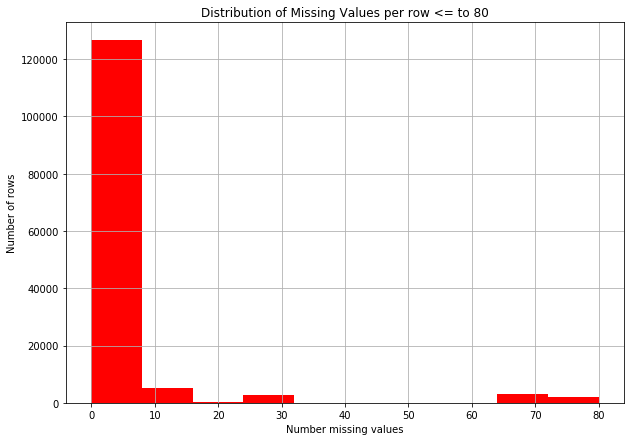

In [29]:
row_null_customers = customers[customers.isnull().sum(axis=1) <=80].isnull().sum(axis=1)

fig = plt.figure(figsize=(10,7))
row_null_customers.hist(color='r')
plt.title('Distribution of Missing Values per row <= to 80');
plt.xlabel('Number missing values')
plt.ylabel('Number of rows');

We can see that about 73% of the lines have between 0 and 80 missing values, with that we will remove the lines that have more than 80 missing values.

### Preprocessing data

In [30]:
#Now let's remove the columns that have more than 30% of missing data, which represents only 6 columns.
columns_removed = azdias.columns[azdias.isnull().mean()>0.30]
print(columns_removed)

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')


In [31]:
#Removing lines that have up to 30 missing values
rows_removed = azdias.loc[azdias.isnull().sum(axis=1) > 30]

rows_removed = azdias.drop(rows_removed.index)
print(rows_removed.index)

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            891211, 891212, 891213, 891214, 891215, 891216, 891217, 891218,
            891219, 891220],
           dtype='int64', length=750584)


In [32]:
#Dropping the columns

azdias_new = rows_removed.drop(columns_removed, axis=1)


In [33]:
azdias_new.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,4.0,0.0,0.0,1.0,3.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,14.0,6.0,0.0,0.0,1.0,5.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,16.0,2.0,1.0,0.0,1.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,17.0,9.0,0.0,0.0,1.0,7.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3
10,645165,0,1.0,10.0,10.0,6.0,0.0,0.0,1.0,6.0,...,4.0,8.0,11.0,10.0,6.0,9.0,5.0,3,2,3


In [34]:
np.where(pd.isnull(azdias_new))

(array([     0,      0,      0, ..., 750583, 750583, 750583]),
 array([32, 49, 53, ..., 73, 81, 88]))

### Reecoding features

The file loading below contains information about each resource and will be used to help decide what needs to be done in the project to adjust and clean the data.

The file DIAS Attributes - Values 2017.xlsx will be studied for this evaluation. This will help to make cleaning decisions during this phase of the project.

In [35]:
info_data = pd.read_csv('/home/kadichari/kadicharivic/projeto_capstone_Arvato/data_info.csv')

In [36]:
info_data.shape

(324, 4)

In [37]:
info_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 4 columns):
attribute             324 non-null object
information_level     324 non-null object
type                  324 non-null object
missing_or_unknown    324 non-null object
dtypes: object(4)
memory usage: 10.2+ KB


In [38]:
# Set attribute as index for `info_data` dataframe
info_data.set_index('attribute', inplace=True)

In [39]:
# Delete columns found in the features not found in the general population dataframe
data_aux = np.setdiff1d(info_data.index, azdias_new.columns, assume_unique=True)
info_data.drop(data_aux, inplace=True)
info_data

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...
PLZ8_HHZ,plz8,ordinal,[-1]
PLZ8_GBZ,plz8,ordinal,[-1]
ARBEIT,community,ordinal,"[-1,9]"


In [40]:
#Checks resources that exist in the azdias_new dataset and that do not exist in data_info
data_missing = np.setdiff1d(azdias_new.columns, info_data.index, assume_unique=True)
print('There are {} missing features.'.format(len(data_missing)))
data_missing

There are 48 missing features.


array(['LNR', 'AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1',
       'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
       'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
       'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR',
       'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1',
       'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX',
       'KBA13_CCM_1401_2500', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210',
       'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ',
       'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT',
       'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA',
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11'], dtype=object)

There are 48 resources that are present in the azdias_new dataset, but are not present in data_info, which consists of the information combination of the DIAS Information Levels & Attributes file provided to us. Therefore, we do not know how necessary this information is, but it is important to evaluate the processing time and memory that we have available, so we decide to remove these 48 resources, another important fact is that these 48 resources have a very large correlation, except of few, with other resources already existing in info_data.

In [41]:
print(data_missing.tolist())

['LNR', 'AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11']


In [42]:
azdias_new.drop(data_missing.tolist(), axis=1, inplace=True)

In [43]:
azdias_new.shape

(750584, 312)

Now let's check the missing_or_unknown column elements of the info_data dataset

In [44]:
info_data["missing_or_unknown"].value_counts()

[-1]        131
[]           73
[-1, 9]      59
[-1,9]       17
[-1,0]       16
[0]          12
[-1,0,9]      1
[-1,XX]       1
[-1,X]        1
[XX]          1
Name: missing_or_unknown, dtype: int64

We can notice that there are missing values, represented by X and XX, therefore, it is necessary to pass those from X and XX to string.

In [45]:
info_data["missing_or_unknown"] = info_data["missing_or_unknown"].replace('[-1,X]', "[-1, 'X']")
info_data["missing_or_unknown"] = info_data["missing_or_unknown"].replace('[XX]', "['XX']")
info_data["missing_or_unknown"] = info_data["missing_or_unknown"].replace('[-1,XX]', "[-1, 'XX']")

info_data["missing_or_unknown"] = info_data["missing_or_unknown"].apply(literal_eval)


In [46]:
info_data['missing_or_unknown'].head()

attribute
AGER_TYP                   [-1, 0]
ALTERSKATEGORIE_GROB    [-1, 0, 9]
ANREDE_KZ                  [-1, 0]
CJT_GESAMTTYP                  [0]
FINANZ_MINIMALIST             [-1]
Name: missing_or_unknown, dtype: object

In [47]:
info_data["type"].value_counts()

ordinal        254
categorical     43
numeric          7
mixed            7
interval         1
Name: type, dtype: int64

We will identify which resources are within the categorical, if they are binary or if they have several levels.

In [48]:
categ_bin_mult = info_data[info_data['type'] == 'categorical']

In [49]:
len(categ_bin_mult)

43

In [50]:
categ_bin = []
categ_mult = []

for idx_cat in categ_bin_mult.index:
    if len(azdias_new[idx_cat].value_counts()) == 2:
        print(azdias_new[idx_cat].value_counts())
        categ_bin.append(idx_cat)
    else:
        categ_mult.append(idx_cat)
        print(azdias_new[idx_cat].value_counts())
        

-1    550578
 2     89402
 1     78234
 3     24564
 0      7806
Name: AGER_TYP, dtype: int64
2    391542
1    359042
Name: ANREDE_KZ, dtype: int64
4.0    185233
3.0    137022
2.0    136362
5.0    106502
6.0     93963
1.0     87819
Name: CJT_GESAMTTYP, dtype: int64
6    282262
1    187021
5    101560
2     96521
4     53340
3     29880
Name: FINANZTYP, dtype: int64
12.0    120683
10.0     98306
8.0      79426
11.0     71398
5.0      68298
4.0      59081
9.0      52351
3.0      52192
1.0      48571
7.0      38229
2.0      33518
6.0      24848
Name: GFK_URLAUBERTYP, dtype: int64
0    585403
1    165181
Name: GREEN_AVANTGARDE, dtype: int64
1.0     382109
10.0    122912
2.0      92253
11.0     46363
0.0      25291
8.0      19635
7.0      16389
4.0      10545
5.0      10371
9.0       9892
6.0       6992
3.0       4149
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    382109
5.0    179167
2.0     92253
4.0     43016
0.0     25291
3.0     25065
Name: LP_FAMILIE_GROB, dtype: int64
1.0     200676
9.0 

Analyzing the data above we can identify that it is necessary to recode the data of the resource OST_WEST_KZ to numbers

#### Recoding binary features

In [51]:
azdias_new['OST_WEST_KZ'] = azdias_new['OST_WEST_KZ'].replace({'O':0.0, 'W':1.0})

In [52]:
azdias_new['OST_WEST_KZ'].value_counts()

1.0    591051
0.0    159533
Name: OST_WEST_KZ, dtype: int64

#### Recoding multilevel features

In [53]:
len(categ_mult)

39

In [54]:
# One-hot encoding to create dummy variables for the multi-level columns
azdias_new_enc = pd.get_dummies(azdias_new, columns=categ_mult)

In [55]:
azdias_new_enc.shape

(750584, 648)

#### Recoding mixed features

In [56]:
mixed = info_data[info_data['type'] == 'mixed']

In [57]:
mixed

,information_level,type,missing_or_unknown
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
WOHNLAGE,building,mixed,[-1]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
PLZ8_BAUMAX,plz8,mixed,"[-1, 0]"


In [58]:
azdias_new_enc['PRAEGENDE_JUGENDJAHRE'].value_counts()

14    171311
8     133113
5      81589
10     79654
3      51775
15     38846
11     32463
9      32213
0      25184
6      25167
12     23093
4      20120
1      19684
2       7381
13      5127
7       3864
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [59]:
decade1 = [1, 3, 5, 7, 9, 11, 13, 15]
decade2 = [2, 4, 6, 8, 10, 12, 14]

In [60]:
azdias_new_enc['DECADE'] = azdias_new_enc['PRAEGENDE_JUGENDJAHRE']

main = azdias_new_enc['PRAEGENDE_JUGENDJAHRE'].isin(decade1)
azdias_new_enc.loc[main, 'MOVEMENT'] = 1.0
avant = azdias_new_enc['PRAEGENDE_JUGENDJAHRE'].isin(decade2)
azdias_new_enc.loc[avant, 'MOVEMENT'] = 2.0

In [61]:
azdias_new_enc['MOVEMENT'].value_counts()

2.0    459839
1.0    265561
Name: MOVEMENT, dtype: int64

In [62]:
azdias_new_enc['CAMEO_INTL_2015'].value_counts()

51      75871
51.0    54882
41      51310
24      49351
41.0    37303
24.0    35687
14      34125
43      31339
54      25547
14.0    24576
43.0    22971
25      21574
54.0    18692
22      17442
25.0    15922
45      14703
13      14075
55      13161
22.0    12847
52      11619
23      11604
45.0    10553
13.0    10250
34      10247
55.0     9674
15       9407
31       9405
52.0     8558
23.0     8304
44       8168
34.0     7421
12       6870
15.0     6866
31.0     6862
44.0     6023
35       5834
32       5686
33       5333
12.0     5052
35.0     4096
32.0     4024
33.0     3754
XX        288
Name: CAMEO_INTL_2015, dtype: int64

In [63]:
azdias_new.isnull().sum()

AGER_TYP                   0
ALTER_HH                   0
ANZ_HAUSHALTE_AKTIV        0
ANZ_HH_TITEL            3344
ANZ_PERSONEN               0
                        ... 
WOHNDAUER_2008             0
WOHNLAGE                   0
ZABEOTYP                   0
ANREDE_KZ                  0
ALTERSKATEGORIE_GROB       0
Length: 312, dtype: int64

In [64]:
azdias_new_enc['CAMEO_INTL_2015'] = azdias_new_enc['CAMEO_INTL_2015'].fillna(-1)
azdias_new_enc['CAMEO_INTL_2015'] = azdias_new_enc['CAMEO_INTL_2015'].replace('XX',-1)
azdias_new_enc['CAMEO_INTL_2015'] = azdias_new_enc['CAMEO_INTL_2015'].astype(int)

In [65]:
azdias_new_enc['WEALTH'] = azdias_new_enc['CAMEO_INTL_2015'] // 10

azdias_new_enc['LIFE_STAGE'] = azdias_new_enc['CAMEO_INTL_2015'] % 10

In [66]:
azdias_new_enc['WOHNLAGE'].value_counts().sort_index()

0.0        20
1.0     41907
2.0     95759
3.0    239530
4.0    130574
5.0     70144
7.0    163364
8.0      9286
Name: WOHNLAGE, dtype: int64

In [67]:
azdias_new_enc['LP_LEBENSPHASE_GROB'].value_counts().sort_index()

0.0      40506
1.0     126800
2.0     145422
3.0      98105
4.0      49516
5.0      42580
6.0      25065
7.0      19884
8.0      23132
9.0      44111
10.0     37341
11.0     28617
12.0     65822
Name: LP_LEBENSPHASE_GROB, dtype: int64

In [68]:
azdias_new_enc['PLZ8_BAUMAX'].value_counts().sort_index()

1.0    475768
2.0     69140
3.0     50127
4.0     55971
5.0     96005
Name: PLZ8_BAUMAX, dtype: int64

In [69]:
azdias_new_enc['KBA05_BAUMAX'].value_counts().sort_index()

0.0    338965
1.0    207638
2.0      9622
3.0     59724
4.0     37380
5.0     97255
Name: KBA05_BAUMAX, dtype: int64

In [70]:
azdias_new_enc = pd.get_dummies(azdias_new_enc, columns=['LP_LEBENSPHASE_GROB', 'WOHNLAGE'])

In [71]:
azdias_new_enc

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_INTL_2015,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,...,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,WOHNLAGE_0.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
1,0.0,11.0,0.0,2.0,0.0,3.0,6.0,51,0,0,...,0,0,0,0,0,0,1,0,0,0
2,17.0,10.0,0.0,1.0,0.0,3.0,2.0,24,0,0,...,0,0,0,0,1,0,0,0,0,0
3,13.0,1.0,0.0,0.0,0.0,2.0,4.0,12,0,0,...,0,0,0,0,0,0,0,0,1,0
4,20.0,3.0,0.0,4.0,0.0,4.0,2.0,43,1,2,...,0,0,0,0,0,1,0,0,0,0
5,10.0,5.0,0.0,1.0,0.0,2.0,6.0,54,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,17.0,15.0,0.0,1.0,0.0,NaN,6.0,41,0,0,...,0,0,0,0,0,1,0,0,0,0
891217,16.0,11.0,0.0,1.0,0.0,4.0,7.0,51,0,0,...,0,0,0,0,0,0,0,1,0,0
891218,17.0,3.0,0.0,0.0,0.0,2.0,5.0,24,6,0,...,0,0,0,0,0,0,0,0,1,0
891219,0.0,7.0,0.0,1.0,0.0,4.0,2.0,51,0,0,...,0,0,0,0,0,0,0,1,0,0


There were several ways to deal with mixed resources. The details are described below:

* LP_LEBENSPHASE_FEIN - It was discarded because it had many levels that may not be captured accurately.
* LP_LEBENSPHASE_GROB - This can be treated as categorical and therefore has been recoded using one-hot encoding.
* PRAEGENDE_JUGENDJAHRE - This was developed using the procedures described above.
* WOHNLAGE - This can be treated as categorical and has been recoded using one-hot coding.
* CAMEO_INTL_2015 - This was designed using the procedures described above.
* PLZ8_BAUMAX - This can be treated as an interval so that nothing has been done. KBA05_BAUMAX - This can be treated as an interval so that nothing has been done

In [72]:
azdias_official = azdias_new_enc.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=1)

In [73]:
#Converts NaNs to -1

azdias_official = azdias_official.replace([np.inf, -np.inf], np.nan)
azdias_official = azdias_official.fillna(-1)

In [74]:
azdias_official.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,WOHNLAGE_0.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
1,0.0,11.0,0.0,2.0,0.0,3.0,6.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,17.0,10.0,0.0,1.0,0.0,3.0,2.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,13.0,1.0,0.0,0.0,0.0,2.0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,20.0,3.0,0.0,4.0,0.0,4.0,2.0,1,2,0,...,0,0,0,0,0,1,0,0,0,0
5,10.0,5.0,0.0,1.0,0.0,2.0,6.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [75]:
azdias_official.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750584 entries, 1 to 891220
Columns: 669 entries, ALTER_HH to WOHNLAGE_8.0
dtypes: float64(206), int64(463)
memory usage: 3.7 GB


In [76]:
np.any(np.isnan(azdias_official))

False

In [77]:
np.where(pd.isnull(azdias_official))

(array([], dtype=int64), array([], dtype=int64))

#### Creating the dataset preprocessing function

In [3]:
def clean_data(df_input):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    #Now let's remove the columns that have more than 30% of missing data, which represents only 6
    columns_removed = df_input.columns[df_input.isnull().mean()>0.30]
    
    #Removing lines that have up to 30 missing values
    rows_removed = df_input.loc[df_input.isnull().sum(axis=1) > 30]
    
    # remove selected rows
    rows_removed = df_input.drop(rows_removed.index)
    
    # remove selected columns
    df_input_new = rows_removed.drop(columns_removed, axis=1)
        
    data_missing_48_col = ['LNR', 'AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1',
       'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
       'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
       'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR',
       'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1',
       'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX',
       'KBA13_CCM_1401_2500', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210',
       'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ',
       'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT',
       'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA',
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11']
    
    #There are 48 resources that are present in the azdias_new dataset,
    #but are not present in data_info, so we will remove
    df_input_new.drop(data_missing_48_col, axis=1, inplace=True)
        
    #Recoding binary features
    df_input_new['OST_WEST_KZ'] = df_input_new['OST_WEST_KZ'].replace({'O':0.0, 'W':1.0})
    
    #Recoding multilevel features
    categ_mult = ['AGER_TYP',
                 'CJT_GESAMTTYP',
                 'FINANZTYP',
                 'GFK_URLAUBERTYP',
                 'LP_FAMILIE_FEIN',
                 'LP_FAMILIE_GROB',
                 'LP_STATUS_FEIN',
                 'LP_STATUS_GROB',
                 'NATIONALITAET_KZ',
                 'SHOPPER_TYP',
                 'TITEL_KZ',
                 'VERS_TYP',
                 'ZABEOTYP',
                 'D19_KONSUMTYP',
                 'D19_GESAMT_ANZ_12',
                 'D19_GESAMT_ANZ_24',
                 'D19_BANKEN_ANZ_12',
                 'D19_BANKEN_ANZ_24',
                 'D19_GESAMT_OFFLINE_DATUM',
                 'D19_GESAMT_ONLINE_DATUM',
                 'D19_GESAMT_DATUM',
                 'D19_BANKEN_OFFLINE_DATUM',
                 'D19_BANKEN_ONLINE_DATUM',
                 'D19_BANKEN_DATUM',
                 'D19_TELKO_OFFLINE_DATUM',
                 'D19_TELKO_ONLINE_DATUM',
                 'D19_TELKO_DATUM',
                 'D19_VERSAND_OFFLINE_DATUM',
                 'D19_VERSAND_ONLINE_DATUM',
                 'D19_VERSAND_DATUM',
                 'D19_VERSI_OFFLINE_DATUM',
                 'D19_VERSI_ONLINE_DATUM',
                 'D19_VERSI_DATUM',
                 'D19_GESAMT_ONLINE_QUOTE_12',
                 'D19_BANKEN_ONLINE_QUOTE_12',
                 'D19_VERSAND_ONLINE_QUOTE_12',
                 'GEBAEUDETYP',
                 'CAMEO_DEUG_2015',
                 'CAMEO_DEU_2015']

    df_input_enc = pd.get_dummies(df_input_new, columns=categ_mult)
    
    #Recoding mixed features
    decade1 = [1, 3, 5, 7, 9, 11, 13, 15]
    decade2 = [2, 4, 6, 8, 10, 12, 14]
    
    df_input_enc['DECADE'] = df_input_enc['PRAEGENDE_JUGENDJAHRE']

    main = df_input_enc['PRAEGENDE_JUGENDJAHRE'].isin(decade1)
    df_input_enc.loc[main, 'MOVEMENT'] = 1.0
    avant = df_input_enc['PRAEGENDE_JUGENDJAHRE'].isin(decade2)
    df_input_enc.loc[avant, 'MOVEMENT'] = 2.0
    
    df_input_enc['CAMEO_INTL_2015'] = df_input_enc['CAMEO_INTL_2015'].replace(np.nan,-1)
    df_input_enc['CAMEO_INTL_2015'] = df_input_enc['CAMEO_INTL_2015'].replace('XX',-1)
    df_input_enc['CAMEO_INTL_2015'] = df_input_enc['CAMEO_INTL_2015'].astype(int)
    
    df_input_enc['WEALTH'] = df_input_enc['CAMEO_INTL_2015'] // 10
    df_input_enc['LIFE_STAGE'] = df_input_enc['CAMEO_INTL_2015'] % 10
    
    df_input_enc = pd.get_dummies(df_input_enc, columns=['LP_LEBENSPHASE_GROB', 'WOHNLAGE'])
    
    df_input = df_input_enc.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=1)
    
    df_input = df_input.replace([np.inf, -np.inf], np.nan)
    df_input = df_input.fillna(-1)
    
    # Return the cleaned dataframe.
    return df_input

In [79]:
azdias_clone = clean_data(azdias_test)

In [80]:
azdias_official.shape

(750584, 669)

In [81]:
azdias_clone.shape

(750584, 669)

In [82]:
# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.
pickle.dump(azdias_official, open("azdias_official.pickle", "wb"))


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Perform Dimensionality Reduction

* Use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
* Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's plot() function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
* Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [4]:
# Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
azdias_official = pickle.load(open("azdias_official.pickle", "rb"))

In [5]:
azdias_official.shape

(750584, 669)

In [6]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_official)

/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [7]:
# Apply PCA to the data.
n_components = None # Half the number of features

pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_scaled)

In [8]:
# The scree_plot function was taken from class notes.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

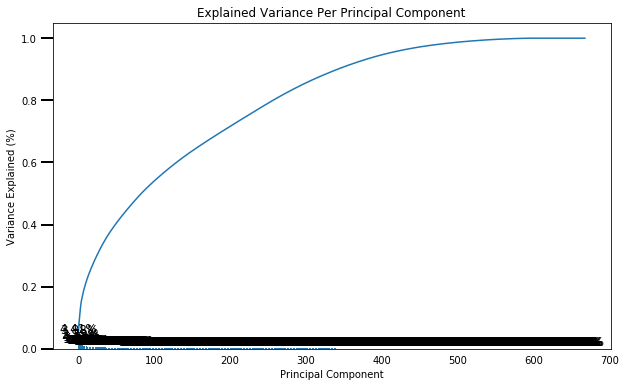

In [9]:
# Investigate the variance accounted for by each principal component
# when all components are calculated
scree_plot(pca)

In [10]:
sum(pca.explained_variance_ratio_)

0.9999999999999996

In order to perform dimensionality reduction, we do not have a clear way to choose the number of components, so we will follow the recommendation to use half the number of resources for the analysis of the main components of the data

In [11]:
n_components = int(azdias_official.shape[1] / 2) # Half the number of features

pca_1 = PCA(n_components)
azdias_pca_1 = pca_1.fit_transform(azdias_scaled)

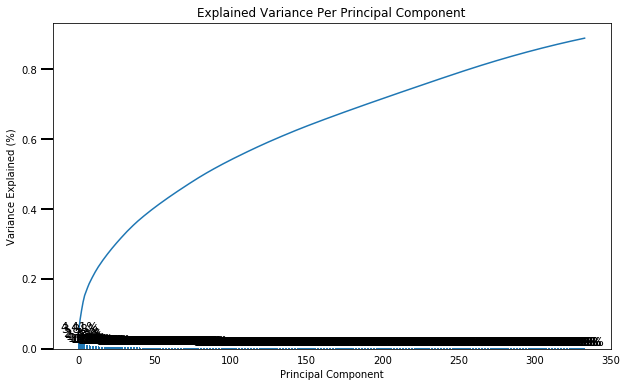

In [12]:
scree_plot(pca_1)

In [13]:
sum(pca_1.explained_variance_ratio_)

0.8884125973334583

With 334 components we obtained 88% of the variability in the original data set.
Now let's check the weight of each variable.


In [14]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca_1.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca_1.components_, 4), columns = azdias_official.keys())
components.index = dimensions

In [15]:
components.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,WOHNLAGE_0.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
Dimension 1,-0.0689,0.0664,0.0165,-0.0979,-0.0023,0.0618,-0.0441,-0.0688,-0.0516,-0.0291,...,-0.0454,-0.0636,-0.0004,-0.0139,-0.0085,0.0156,0.0367,0.0310,-0.0537,-0.0182
Dimension 2,-0.0009,0.0000,0.0046,0.0176,0.0029,-0.0294,0.0105,0.0055,0.0034,0.0062,...,0.0111,0.0213,0.0012,0.0116,0.0051,-0.0079,-0.0162,-0.0116,0.0194,0.0075
Dimension 3,0.0640,0.0511,0.0056,0.0384,-0.0073,0.0772,-0.0335,0.0750,0.0628,0.0107,...,0.0122,-0.0251,0.0005,-0.0315,-0.0168,0.0157,0.0368,0.0353,-0.0442,-0.0045
Dimension 4,0.0144,0.0361,0.0293,-0.0009,0.0113,-0.0174,-0.1050,0.0201,0.0203,-0.0051,...,0.0006,-0.0223,0.0003,0.0502,0.0301,0.0187,0.0179,0.0036,-0.0868,-0.0206
Dimension 5,-0.0121,0.0398,0.0243,0.0268,0.0123,0.0826,-0.0629,0.0136,0.0081,0.0056,...,-0.0292,0.0515,-0.0003,0.0164,0.0141,0.0351,0.0163,0.0071,-0.0741,-0.0231


In [16]:
components.iloc[1].sort_values(ascending=False)

KBA05_SEG6            0.1761
KBA05_KRSOBER         0.1615
KBA05_KRSVAN          0.1583
KBA05_KRSZUL          0.1580
KBA05_ANHANG          0.1558
                       ...  
PLZ8_ANTG3           -0.0394
LP_STATUS_GROB_1.0   -0.0397
WEALTH               -0.0403
KBA05_ANTG3          -0.0443
HH_EINKOMMEN_SCORE   -0.0460
Name: Dimension 2, Length: 669, dtype: float64

In [17]:
components.iloc[2].sort_values(ascending=False)

FINANZ_SPARER          0.1167
ONLINE_AFFINITAET      0.1047
DECADE                 0.1016
LP_STATUS_GROB_1.0     0.0982
D19_VERSAND_ANZ_24     0.0975
                        ...  
D19_BANKEN_DATUM_10   -0.0940
D19_GESAMT_ANZ_12_0   -0.0957
PLZ8_ANTG1            -0.0962
FINANZ_VORSORGER      -0.1065
FINANZ_MINIMALIST     -0.1104
Name: Dimension 3, Length: 669, dtype: float64

#### Interpret Principal Components

* The first component increases with the high number of total transaction activity in the last 24 months and decreases with online affinity.

* The second component has a high number for car ownership, as people who own high class cars. And the component of the estimated net income of families decreases.

* The third component is related to finance, describing a person who saves money and transacts on the internet, and the number decreases with low financial interest.

### Perform K-Means Clustering

To perform the segmentation we will use the k-means cluster to group data in similar clusters. Recalling that the k-means clustering algorithm can be divided into a few steps, these being:
* Find the centroid at which the point is closest
* Assign this point to this cluster
* For each centroid of the cluster, it is necessary to move this point so that it is in the center of all points assigned to that cluster.
* Repeat the previous steps until convergence is achieved and the points no longer change the cluster association or until the specified number of iterations has been reached.

In [18]:
score_list = []
centers = list(range(1,40))

for center in centers:
    kmeans = MiniBatchKMeans(n_clusters=center, random_state=42)
    model = kmeans.fit(azdias_pca_1)
    
    score = np.abs(model.score(azdias_pca_1))
    score_list.append(score)

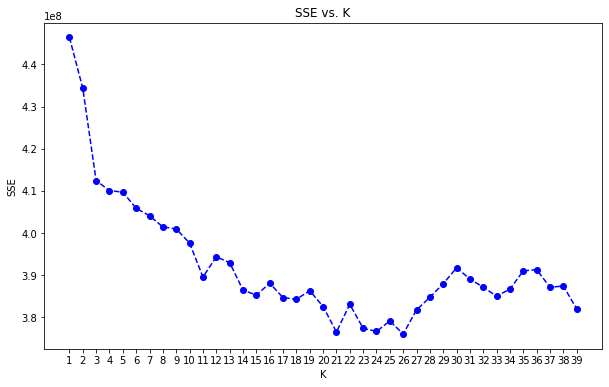

In [19]:
plt.figure(figsize=(10, 6))
ax = plt.subplot()
plt.plot(centers, score_list, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.xticks(np.arange(1, 40, step=1))
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [20]:
kmeans = KMeans(n_clusters=30, random_state=42, n_jobs=-1)
azdias_preds = kmeans.fit_predict(azdias_pca_1)

In [21]:
azdias_cluster = pd.DataFrame(np.round(azdias_pca_1, 4), columns = dimensions)
azdias_cluster.insert(loc=0, column='Cluster', value=azdias_preds)
azdias_cluster.head(10)

,Cluster,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,...,Dimension 325,Dimension 326,Dimension 327,Dimension 328,Dimension 329,Dimension 330,Dimension 331,Dimension 332,Dimension 333,Dimension 334
0,21,4.2254,-2.3795,0.5738,4.7457,-5.0732,0.8869,1.5146,-2.9610,-1.4194,...,0.5526,-0.0861,-0.4196,-1.0793,-0.6205,0.2952,-0.4378,0.7136,0.4262,-0.6253
1,21,1.1381,-0.3423,-4.5016,2.2312,-2.3655,-1.9793,3.2497,-3.1877,1.9524,...,-0.2701,-1.9695,-0.4518,0.0312,0.8016,-0.3918,-0.7091,0.5393,-1.6539,-0.2331
2,5,-0.8928,1.9652,-7.7033,-1.9176,-1.6598,0.7757,0.3947,-0.6404,-2.5219,...,-1.0016,0.4958,0.8652,0.3498,0.6302,-0.2840,-0.5296,0.1207,0.5994,-0.5562
3,13,-9.4928,1.2828,7.4873,4.7301,3.0882,5.4116,2.3229,6.2491,-0.8355,...,-3.7121,-2.6744,-0.5932,1.8717,-0.3453,-1.3827,-4.4644,-0.0777,1.1676,0.4705
4,23,-0.7185,-0.0585,-3.4442,0.7865,-2.0513,-0.0217,1.0742,-0.6853,-1.8161,...,0.1447,0.1176,-0.4783,-0.0065,0.1694,-0.4319,-0.3123,0.4204,0.1894,0.5646
5,21,3.5929,-2.1591,-0.2826,-2.0677,-5.6711,0.8012,-0.1280,-2.0214,3.6626,...,-0.7337,-0.2223,-0.1623,0.9337,0.7505,0.0919,0.5319,-0.6437,-1.0192,-0.5344
6,21,1.9024,-0.0037,-4.3216,2.7806,-3.1551,-2.6765,0.0321,4.5335,2.3105,...,0.5036,-0.7776,-0.4760,0.7349,0.0110,0.1505,-0.4379,-0.7931,-0.3850,-0.2529
7,9,1.0867,1.1691,-7.3362,6.3320,-1.2156,-0.6355,3.0187,2.5525,2.7325,...,-0.0089,1.3096,-0.9534,-0.0654,0.2645,-0.9358,-0.4347,0.4099,-0.1615,-0.1005
8,9,-5.5859,2.1717,-2.4863,11.0335,2.2918,-3.8483,4.0624,-4.4562,1.6819,...,-0.0606,-1.4409,0.1259,0.6738,-0.1070,-0.1928,0.4462,0.9089,1.3065,0.0585
9,29,3.8326,-6.0567,-0.3414,-3.9719,3.1691,1.8702,-3.4349,-2.6950,2.2825,...,0.0365,-0.0983,0.8004,0.2084,-1.6473,-0.6534,-0.5045,0.0881,0.3967,0.4586


### Preprocessing of customer data

As mentioned at the beginning of this notebook, the Customers file has three extra columns, so we will remove them.

In [5]:
customers_official = clean_data(customers)

In [6]:
customers_official.shape

(135044, 669)

In [7]:
customers_official = customers_official.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

In [8]:
customers_official.shape

(135044, 666)

In [9]:
# Check for missing column in `customers_clean`
customers_missing = list(np.setdiff1d(azdias_official.columns, customers_official.columns))
customers_missing

['D19_BANKEN_ONLINE_QUOTE_12_1.0', 'GEBAEUDETYP_5.0', 'TITEL_KZ_2.0']

In [10]:
for missing in customers_missing:
    customers_official[missing] = 0
    customers_official[missing] = customers_official[missing].astype('uint8')
    
print(customers_official.shape)
customers_official.head()

(135044, 669)


,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,D19_BANKEN_ONLINE_QUOTE_12_1.0,GEBAEUDETYP_5.0,TITEL_KZ_2.0
0,10.0,1.0,0.0,2.0,0.0,1.0,3.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,6.0,1.0,0.0,1.0,0.0,3.0,7.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,8.0,0.0,-1.0,0.0,0.0,1.0,7.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,20.0,7.0,0.0,4.0,0.0,3.0,3.0,5,0,3,...,0,0,1,0,0,0,0,0,0,0
5,11.0,1.0,0.0,2.0,0.0,3.0,7.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
# Dump the customers dataframe to a pickle object since it takes up so much room in memory.
pickle.dump(customers_official, open("customers_official.pickle", "wb"))

In [12]:
# Apply feature scaling to the customer data.
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customers_official)

/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [32]:
customers_pca = pca_1.transform(customers_scaled)
customers_preds = kmeans.predict(customers_pca)


In [33]:
customers_cluster = pd.DataFrame(np.round(customers_pca, 4), columns = dimensions)
customers_cluster.insert(loc=0, column='Cluster', value=customers_preds)
customers_cluster.head(10)

,Cluster,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,...,Dimension 325,Dimension 326,Dimension 327,Dimension 328,Dimension 329,Dimension 330,Dimension 331,Dimension 332,Dimension 333,Dimension 334
0,8,-1.0988,2.6847,-4.8255,0.3657,-0.3653,0.3015,-2.2273,1.5351,0.3291,...,-1.6835,0.0044,0.9232,0.1686,-0.4968,0.4922,-0.5354,0.2012,0.5190,-0.2907
1,29,3.5684,0.6207,-1.2766,0.1242,2.1236,1.7326,-1.6854,-2.4259,1.3674,...,-0.6116,-0.4316,-0.9438,-0.7721,0.1348,0.3155,0.5646,-1.3190,-0.5225,0.2503
2,5,-0.7359,-0.1434,-0.9875,-2.6691,-1.8887,-2.2839,3.0093,1.5735,-3.4493,...,0.8399,0.8978,0.0250,0.9447,-0.6894,-0.2574,-0.5578,0.6974,-1.1604,1.1562
3,26,0.1124,-4.3064,5.1635,-1.1377,-2.5479,3.1317,-1.5737,0.5214,2.9564,...,-0.0764,0.4479,-0.4420,0.7452,0.0655,0.5684,-0.8852,0.2786,-0.1116,1.1103
4,9,-0.3550,2.0156,-2.8004,5.4790,1.1003,-2.1319,0.1954,2.4501,-0.4525,...,1.6285,-0.2343,-0.6681,0.0756,0.1800,1.3890,-1.1419,0.0548,1.2015,0.3711
5,19,-3.4630,1.7184,-1.6313,-0.9537,0.3428,2.0228,-1.4450,1.5361,0.0384,...,-1.7808,-0.7289,-1.6034,-0.6927,-0.0315,-0.6862,0.4046,-0.5321,1.3294,-0.2807
6,8,-0.9091,1.2305,-5.3586,3.1099,0.7433,-3.8467,3.2580,2.0098,0.6007,...,-1.1158,0.3824,0.7664,1.1667,-0.1961,0.3704,0.5385,-0.7774,0.5322,0.5700
7,18,6.7642,-5.0485,0.3843,7.8257,6.0330,-1.2013,3.4981,-2.6337,-4.1248,...,-0.7015,-0.2227,0.0976,-0.3609,2.4378,-0.0862,-0.4767,-1.4077,-1.3639,-0.7964
8,20,-4.8233,1.9248,1.0289,5.2224,-0.1020,-0.6045,0.3943,2.1456,1.6310,...,-0.0547,-0.8767,-0.3906,-1.0805,-1.6006,2.0417,-0.9219,0.9931,-0.6520,0.8776
9,11,-4.7165,1.3323,1.2766,-1.2807,-1.8238,1.9402,2.1447,3.7179,0.7434,...,0.4574,0.2086,-0.7923,-0.4048,-0.0972,-0.4999,0.2506,-1.4365,0.7563,0.0337


#### Compare Customer Data to Demographics Data

In [95]:
def segment_plot(df1_cluster, df2_cluster, title='Default Title'):
    '''
    Input: df1, df2 - (DataFrames) to be compared (features should be exactly the same)
           df1_cluster_ID, df2_cluster_ID - (DataFrames) of predicted cluster IDs for df1 and df2
           labels - (list) of names for the two data sources
    '''
    cluster_counts1 = df1_cluster['Cluster'].value_counts()
    cluster_order1 = cluster_counts1.index
    
    cluster_counts2 = df2_cluster['Cluster'].value_counts()
    cluster_order2 = cluster_counts2.index
    
    #compute largest proportion
    n_model1 = df1_cluster.shape[0]
    max_cluster_count1 = cluster_counts1.iloc[0]
    max_prop1 = max_cluster_count1 / n_model1
    
    n_model2 = df2_cluster.shape[0]
    max_cluster_count2 = cluster_counts2.iloc[0]
    max_prop2 = max_cluster_count2 / n_model2
    
    
    #establish tick locations and create plot
    tick_props1 = np.arange(0, max_prop1, 0.01)
    tick_names1 = ['{:0.2f}'.format(v) for v in tick_props1]
    
    

    sns.countplot(data=df1_cluster, x='Cluster', color="pink", order=cluster_order1)
    sns.countplot(data=df2_cluster, x='Cluster', color="blue", order=cluster_order2)
    plt.yticks(tick_props1 * n_model1, tick_names1)
    plt.ylabel('Percentage')
    plt.title(title);



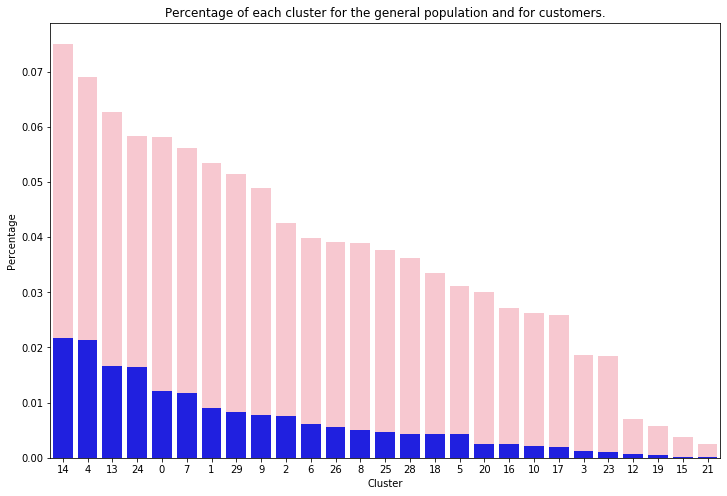

In [96]:
fig, ax = plt.subplots(figsize=(12,8))
segment_plot(azdias_cluster, customers_cluster, title='Percentage of each cluster for the general population and for customers.')

In the graph above, what is in pink represents the clusters of the general population and in blue the customers of clusters

In [52]:
azdias_percent = azdias_cluster['Cluster'].value_counts() / azdias_cluster.shape[0]
customers_percent = customers_cluster['Cluster'].value_counts() / customers_cluster.shape[0]
difference = customers_percent - azdias_percent

In [111]:
difference.sort_values(ascending=False)

4     0.064803
24    0.052452
14    0.051346
13    0.036743
1     0.010399
0     0.008965
29    0.008431
9     0.004074
26    0.003543
6     0.003516
7     0.002792
23    0.002457
8     0.002210
21   -0.001801
19   -0.003347
15   -0.005995
2    -0.009755
20   -0.011569
3    -0.012049
5    -0.012562
12   -0.014414
28   -0.018172
10   -0.018810
16   -0.019977
18   -0.034386
17   -0.037662
25   -0.049278
11         NaN
22         NaN
27         NaN
Name: Cluster, dtype: float64

Analyzing the above values, we can see that the underrepresented cluster is 25 with a difference of -0.049278, while the overrepresented cluster is cluster 4 with a difference of 0.064803.

In [99]:
customers_clust = pd.Series(customers_preds)
customers_clust = customers_clust.value_counts().sort_index()
population_clust = pd.Series(azdias_preds)
population_clust = population_clust.value_counts().sort_index()

In [70]:
data_status =  pd.DataFrame(columns=['Cluster', 'Difference', 'Customers', 'General'])

In [100]:
data_status['Cluster'] = difference.index
data_status['Difference'] = difference.values
data_status['Customers'] = customers_clust
data_status['General'] = population_clust

In [85]:
data_status

,Cluster,Difference,Customers,General
0,0,0.008965,9055.0,43599
1,1,0.010399,6787.0,29917
2,2,-0.009755,5630.0,38614
3,3,-0.012049,895.0,14018
4,4,0.064803,15978.0,40167
5,5,-0.012562,3184.0,27126
6,6,0.003516,4545.0,22622
7,7,0.002792,8848.0,47082
8,8,0.002210,3840.0,19684
9,9,0.004074,5804.0,29201


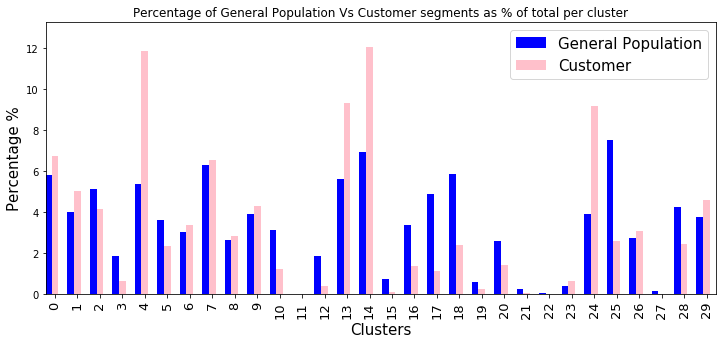

In [101]:
# proportion of data in each cluster for the general population.
# Add ratio and ratio difference for each cluster to the dataframe
data_status['General_proportion'] = (data_status['General']/data_status['General'].sum()*100).round(2)
data_status['Customers_proportion'] = (data_status['Customers']/data_status['Customers'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = data_status['General_proportion'].plot(x=data_status['Cluster'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = data_status['Customers_proportion'].plot(kind='bar',color='pink',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Percentage %', fontsize=15)
ax.xaxis.set(ticklabels=range(30))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('General Population', 'Customer'),fontsize=15)
plt.title(('Percentage of General Population Vs Customer segments as % of total per cluster'))
plt.show()

In [108]:
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca_1.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca_1.components_, columns = azdias_official.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [110]:
#Show highest positive and negative weights for 4 cluster (over representation)
pca_weights(4,5)

Principal Component:  4


Highest Positive weights:
KBA13_HERST_BMW_BENZ           0.187
KBA13_SEG_OBEREMITTELKLASSE    0.163
KBA13_BMW                      0.158
KBA13_MERCEDES                 0.158
KBA13_SITZE_4                  0.151
Name: 3, dtype: float64


Negative weights:
KBA13_SITZE_5          -0.152
KBA13_KMH_140_210      -0.133
KBA13_SEG_KLEINWAGEN   -0.131
KBA13_HALTER_20        -0.127
KBA13_HALTER_25        -0.120
Name: 3, dtype: float64


/home/kadichari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  


In [112]:
# Show lowest positive and negative weights for 25 cluster (under representation)
pca_weights(25,5)

Principal Component:  25


Highest Positive weights:
ANZ_TITEL             0.180
TITEL_KZ_1.0          0.179
LP_STATUS_GROB_3.0    0.163
LP_STATUS_FEIN_7.0    0.150
KBA05_CCM1            0.145
Name: 24, dtype: float64


Negative weights:
TITEL_KZ_0.0         -0.187
LP_STATUS_GROB_2.0   -0.122
KBA05_KW2            -0.117
KBA13_VORB_0         -0.114
KBA13_KRSZUL_NEU     -0.112
Name: 24, dtype: float64


/home/kadichari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  


Each individual can be divided into 30 groupings. The graph above shows the distribution comparing the General population and the customer population. Looking at the data, we can conclude that the strongest basis for becoming a customer is in clusters where the customer population represents the majority of the general population's graphs, which in our case are clusters 4, 13, 14 and 24.
And in the data above it is possible to analyze the resources that have more weight until less weight for the cluster under representation in case 25 and for over representation which is cluster 4.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

#### Preprocessing of the MAILOUT_052018_TRAIN dataset

In [5]:
mailout_train = pd.read_csv('/home/kadichari/kadicharivic/projeto_capstone_Arvato/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [6]:
mailout_train.shape

(42962, 367)

In [7]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [8]:
mailout_train_clean = clean_data(mailout_train)

In [9]:
mailout_train_clean.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
0,8.0,15.0,0.0,1.0,0.0,3.0,5.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,13.0,1.0,0.0,2.0,0.0,2.0,5.0,0,0,3,...,0,0,0,0,0,0,0,0,1,0
2,9.0,0.0,-1.0,0.0,0.0,4.0,1.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,6.0,4.0,0.0,2.0,0.0,4.0,2.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,9.0,53.0,0.0,1.0,0.0,3.0,4.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
# Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
customers_official = pickle.load(open("customers_official.pickle", "rb"))

In [11]:
# Check for missing column in `mailout_train_clean`
missing = list(np.setdiff1d(customers_official.columns, mailout_train_clean.columns))
missing

['D19_BANKEN_ONLINE_QUOTE_12_1.0',
 'D19_BANKEN_ONLINE_QUOTE_12_4.0',
 'D19_BANKEN_ONLINE_QUOTE_12_6.0',
 'GEBAEUDETYP_5.0',
 'TITEL_KZ_2.0',
 'WOHNLAGE_0.0']

In [12]:
# Add the missing column with default value of 0
for missings in missing:
    mailout_train_clean[missings] = 0
    mailout_train_clean[missings] = mailout_train_clean[missings].astype('uint8')
    
print(mailout_train_clean.shape)
mailout_train_clean.head()

(34184, 670)


,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,D19_BANKEN_ONLINE_QUOTE_12_1.0,D19_BANKEN_ONLINE_QUOTE_12_4.0,D19_BANKEN_ONLINE_QUOTE_12_6.0,GEBAEUDETYP_5.0,TITEL_KZ_2.0,WOHNLAGE_0.0
0,8.0,15.0,0.0,1.0,0.0,3.0,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13.0,1.0,0.0,2.0,0.0,2.0,5.0,0,0,3,...,0,0,1,0,0,0,0,0,0,0
2,9.0,0.0,-1.0,0.0,0.0,4.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,4.0,0.0,2.0,0.0,4.0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.0,53.0,0.0,1.0,0.0,3.0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#Number of people who did not become a customer
customers = mailout_train_clean[mailout_train_clean['RESPONSE']==0].shape
#Number of people who became customers
not_customers = mailout_train_clean[mailout_train_clean['RESPONSE']==1].shape

In [14]:
print("Number of people who became customers: {}".format(customers[0]))
print("Number of people who did not become a customer: {}".format(not_customers[0]))

Number of people who became customers: 33760
Number of people who did not become a customer: 424


In [15]:
target_response = mailout_train_clean['RESPONSE']
train_features = mailout_train_clean.drop(['RESPONSE'], axis=1)

In [16]:
train_features.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,D19_BANKEN_ONLINE_QUOTE_12_1.0,D19_BANKEN_ONLINE_QUOTE_12_4.0,D19_BANKEN_ONLINE_QUOTE_12_6.0,GEBAEUDETYP_5.0,TITEL_KZ_2.0,WOHNLAGE_0.0
0,8.0,15.0,0.0,1.0,0.0,3.0,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13.0,1.0,0.0,2.0,0.0,2.0,5.0,0,0,3,...,0,0,1,0,0,0,0,0,0,0
2,9.0,0.0,-1.0,0.0,0.0,4.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,4.0,0.0,2.0,0.0,4.0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.0,53.0,0.0,1.0,0.0,3.0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
target_response.value_counts()

0    33760
1      424
Name: RESPONSE, dtype: int64

In [115]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)

# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.
pickle.dump(scaler, open("scaler.pickle", "wb"))


print('Type of train_features_scaled is : {}'.format(type(train_scaled)))

/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Type of train_features_scaled is : <class 'numpy.ndarray'>


/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [104]:
train_scaled

array([[-0.37602473,  0.54864744, -0.09146905, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4468122 , -0.37901574, -0.09146905, ...,  0.        ,
         0.        ,  0.        ],
       [-0.21145735, -0.44527739, -2.67558301, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.94051437, -0.31275408, -0.09146905, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.26964914, -0.24649243, -0.09146905, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4468122 , -0.24649243, -0.09146905, ...,  0.        ,
         0.        ,  0.        ]])

In [19]:
#Making train_features_scaled into a dataframe
train_scaled = pd.DataFrame(train_scaled, columns= list(train_features.columns.values))
print('Type of train_features_scaled now is : {}'.format(type(train_scaled)))
train_scaled.shape

Type of train_features_scaled now is : <class 'pandas.core.frame.DataFrame'>


(34184, 669)

### Conducting training on LogisticRegression, RandomForestClassifier and KNeighborsRegressor models

In [20]:
# Define fit_classifier function to fit different classifiers on training dataset i.e. train_features_scaled
# to find the best performing classifier algorithm
def fit_classifier(classifier, param_grid, X=train_scaled, y=target_response):
    """
    Fits a classifier to its training data using GridSearchCV and calculates ROC AUC score
    
    INPUT:
    - classifier (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=0)
    print("Training {} :".format(classifier.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(classifier.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [21]:
LogisticReg = LogisticRegression(random_state=42)
RandomFor = RandomForestClassifier(random_state=42)
KNN = KNeighborsRegressor()

In [22]:
#best classification algorithm

classifier_names = []
classifier_scores = []
classifier_best_ests = []
classifier_time_taken = []
classifier_dict = {}

for clf in [LogisticReg, RandomFor, KNN]:
    best_score, best_est, time_taken = fit_classifier(clf, {})
    classifier_names.append(clf.__class__.__name__)
    classifier_scores.append(best_score)
    classifier_best_ests.append(best_est)
    classifier_time_taken.append(time_taken)

Training LogisticRegression :


/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be ch

LogisticRegression
Time taken : 95.18 secs
Best score : 0.598
****************************************
Training RandomForestClassifier :


/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/kadichari/anaconda3/lib/py

RandomForestClassifier
Time taken : 4.36 secs
Best score : 0.4999
****************************************
Training KNeighborsRegressor :
KNeighborsRegressor
Time taken : 4362.38 secs
Best score : 0.5063
****************************************


In [23]:
# Create dataframe from clf_dict
classifier_dict['best_score'] = classifier_scores
classifier_dict['time_taken'] = classifier_time_taken
classifier_dict['best_est'] = classifier_best_ests
classifier_df = pd.DataFrame(classifier_dict, index=classifier_names)
classifier_df

,best_score,time_taken,best_est
LogisticRegression,0.597958,95.18,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.499896,4.36,"(DecisionTreeClassifier(class_weight=None, cri..."
KNeighborsRegressor,0.506314,4362.38,"KNeighborsRegressor(algorithm='auto', leaf_siz..."


Observing the table above we can conclude that of the three models the one that obtained the best score was the LogisticRegression, however it is necessary to improve this value. We will do this by changing some hyperparameters of the model.

In [24]:
# Print the best estimator of GradientBoostingClassifier
classifier_df.loc['LogisticRegression', 'best_est']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Improving the LogisticRegression model

In [25]:
hiperparametros = {"penalty":["l1","l2"],
                   "max_iter": [100, 300, 500]}

LogisticReg = LogisticRegression(random_state=42)
LogisticReg_best_score, LogisticReg_best_est, _ = fit_classifier(LogisticReg, hiperparametros)
LogisticReg_best_est


Training LogisticRegression :


/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be ch

LogisticRegression
Time taken : 2661.72 secs
Best score : 0.6028
****************************************


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Saving best model

In [26]:
# pickle file and save the model to disk.
filename = 'LogisticRegression.pkl'
outfile = open(filename, 'wb')
model = LogisticReg_best_est
pickle.dump(model, outfile)
outfile.close()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

#### Preprocessing of the MAILOUT_052018_TEST dataset

In [30]:
mailout_test = pd.read_csv('/home/kadichari/kadicharivic/projeto_capstone_Arvato/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/home/kadichari/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
# Print shape of test dataset
mailout_test.shape

(42833, 366)

In [32]:
# Print first few rows of test dataset
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [71]:
mailout_test['LNR']

0         1754
1         1770
2         1465
3         1470
4         1478
         ...  
42828    67615
42829    67938
42830    67942
42831    67949
42832    68898
Name: LNR, Length: 42833, dtype: int64

In [67]:
#Removing lines that have up to 30 missing values
rows_removed = mailout_test.loc[mailout_test.isnull().sum(axis=1) > 30]

# remove selected rows
rows_removed = mailout_test.drop(rows_removed.index)

In [70]:
LNR = rows_removed['LNR']

In [34]:
#Cleaning dataset
mailout_test_clean = clean_data(mailout_test)

In [35]:
mailout_test_clean.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
0,7.0,2.0,0.0,2.0,0.0,3.0,6.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,20.0,0.0,1.0,0.0,4.0,7.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,16.0,2.0,0.0,4.0,0.0,4.0,1.0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,0.0,1.0,0.0,0.0,0.0,4.0,1.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,21.0,1.0,0.0,4.0,0.0,3.0,6.0,2,2,0,...,0,0,1,0,0,0,0,0,1,0


In [36]:
# Check for missing column in `mailout_test_clean`
missing = list(np.setdiff1d(customers_official.columns, mailout_test_clean.columns))
missing

['D19_BANKEN_ONLINE_QUOTE_12_1.0',
 'D19_VERSI_ONLINE_DATUM_2',
 'GEBAEUDETYP_5.0',
 'TITEL_KZ_2.0',
 'WOHNLAGE_0.0']

In [45]:
# Add the missing column with default value of 0
for missings in missing:
    mailout_test_clean[missings] = 0
    mailout_test_clean[missings] = mailout_test_clean[missings].astype('uint8')
    
print(mailout_test_clean.shape)
mailout_test_clean.head()

(34152, 669)


,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,D19_BANKEN_ONLINE_QUOTE_12_1.0,D19_VERSI_ONLINE_DATUM_2,GEBAEUDETYP_5.0,TITEL_KZ_2.0,WOHNLAGE_0.0
0,7.0,2.0,0.0,2.0,0.0,3.0,6.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.0,20.0,0.0,1.0,0.0,4.0,7.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,16.0,2.0,0.0,4.0,0.0,4.0,1.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0.0,1.0,0.0,0.0,0.0,4.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.0,1.0,0.0,4.0,0.0,3.0,6.0,2,2,0,...,0,0,0,1,0,0,0,0,0,0


In [38]:
type(mailout_test_clean["KBA05_BAUMAX"])

pandas.core.series.Series

In [52]:
type(mailout_test_clean)

pandas.core.frame.DataFrame

In [56]:
scaler = StandardScaler()
test_scaled1 = scaler.fit_transform(mailout_test_clean)
print('Type of train_features_scaled is : {}'.format(type(test_scaled)))

/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Type of train_features_scaled is : <class 'pandas.core.frame.DataFrame'>


/home/kadichari/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [57]:
test_scaled1

array([[-0.53472531, -0.3246943 , -0.08311733, ...,  0.        ,
         0.        ,  0.        ],
       [-1.68318206,  0.91215359, -0.08311733, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.94186194, -0.3246943 , -0.08311733, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.94186194, -0.39340807, -0.08311733, ...,  0.        ,
         0.        ,  0.        ],
       [-1.68318206, -0.39340807, -0.08311733, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61373144, -0.39340807,  2.71631364, ...,  0.        ,
         0.        ,  0.        ]])

In [40]:
#Making train_features_scaled into a dataframe
test_scaled = pd.DataFrame(test_scaled, columns= list(mailout_test_clean.columns.values))
print('Type of train_features_scaled now is : {}'.format(type(test_scaled)))
test_scaled.head(1)

Type of train_features_scaled now is : <class 'pandas.core.frame.DataFrame'>


,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,D19_BANKEN_ONLINE_QUOTE_12_1.0,D19_VERSI_ONLINE_DATUM_2,GEBAEUDETYP_5.0,TITEL_KZ_2.0,WOHNLAGE_0.0
0,-0.534725,-0.324694,-0.083117,-0.024069,-0.095563,-0.022893,0.78524,-0.426904,-0.337565,-0.149108,...,1.45106,-0.386518,-0.24828,-0.607078,-0.09602,0.0,0.0,0.0,0.0,0.0


In [46]:
list(mailout_test_clean.columns.values)

['ALTER_HH',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_TECHNIK',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_MOBILE',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_REST',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSICHERUNGEN',
 'D19_VOLLSORTIMENT',
 'D19_WEIN_FEINKOST',
 'EWDICHTE',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UN

### Testing the best model

In [41]:
test_response = LogisticReg_best_est.predict(test_scaled)

In [42]:
test_response

array([0, 0, 0, ..., 0, 0, 0])

In [58]:
test_response_proba = LogisticReg_best_est.predict_proba(test_scaled)

In [64]:
test_response_proba.shape

(34152, 2)

In [65]:
LNR.shape

(42833,)

In [72]:
kaggle = pd.DataFrame({'LNR': LNR, 'RESPONSE': test_response_proba[:, 1]})
kaggle.head()

,LNR,RESPONSE
0,1754,0.110566
1,1770,0.014949
2,1465,0.000740
3,1470,0.000491
4,1478,0.012286


In [73]:
# Generate CSV file for the Kaggle competition
kaggle.to_csv('kaggle_submission_file.csv', index=False)